# Vanilla classification baseline with timm and albumentations 

- **timm** is a powerful library with various models pretrained on diverse datasets
- **albumentations** is a library for image transformations & augmentations

**Curr progress**:

- DINOv2 small: 99.97% [Top 3]
- Hiera small: 99.94%
- EfficienNet V2 small: [last version]

please upvote if you find this notebook helpful

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import timm
import albumentations as albu
from albumentations.pytorch import ToTensorV2

from PIL import Image
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import f1_score
from tqdm import tqdm
import copy

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
class CustomDataset(Dataset):
    def __init__(self, df, data_dir, transforms=None, is_train=True):
        """
        Args:
            df (pd.DataFrame): DataFrame containing file names and labels.
            data_dir (str): Directory where the image files are stored.
            transforms (albu.Compose, optional): Albumentations transforms to apply to the images.
            is_train (bool, optional): Flag to indicate if the dataset is for training.
        """
        self.df = df
        self.data_dir = data_dir
        self.transforms = transforms
        self.is_train = is_train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Extract the file name and label
        filename = self.df.iloc[idx]['file_name']
        label = self.df.iloc[idx]['label']

        # Load the image
        img_path = os.path.join(self.data_dir, filename)
        image = Image.open(img_path).convert('RGB')  # Ensure image is in RGB mode
        image = np.array(image)  # Convert to NumPy array (Albumentations requires this format)

        # Apply transforms if specified
        if self.transforms:
            image = self.transforms(image=image)['image']

        # For training, return the image and label
        if self.is_train:
            return image, label
        # For inference, return only the image
        else:
            return image


In [3]:
BATCH_SIZE = 16
SEED = 42
IMG_SIZE = 384

# Load the train CSV
train_csv_path = "/kaggle/input/ai-vs-human-generated-dataset/train.csv"
train_df = pd.read_csv(train_csv_path)

# Define the base directory where images are stored
train_data_dir = "/kaggle/input/ai-vs-human-generated-dataset/"

train_transform = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.Resize(IMG_SIZE, IMG_SIZE),
    albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = albu.Compose([
    albu.Resize(IMG_SIZE, IMG_SIZE),
    albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=SEED, stratify=train_df['label'])

# Dataset and DataLoader
train_dataset = CustomDataset(train_df, train_data_dir, transforms=train_transform, is_train=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_dataset = CustomDataset(val_df, train_data_dir, transforms=train_transform, is_train=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


# Iterate through the DataLoader
for images, labels in train_dataloader:
    print(images.shape, labels)
    break

for images, labels in val_dataloader:
    print(images.shape, labels)
    break

torch.Size([16, 3, 384, 384]) tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0])
torch.Size([16, 3, 384, 384]) tensor([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0])


In [4]:
LR = 1e-5
NUM_EPOCHS = 2

# model = timm.create_model('vit_small_patch14_dinov2.lvd142m', 
#                           pretrained=True,
#                          num_classes=2)

model = timm.create_model('tf_efficientnetv2_s.in21k_ft_in1k', 
                          pretrained=True,
                         num_classes=2)

optimizer = Adam(model.parameters(), lr=LR, weight_decay=1e-2)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

In [5]:
def train_model(
    model, train_loader, val_loader, optimizer, scheduler, loss_fn, device, num_epochs=10, save_path="best_model.pth"
):
    """
    Trains the model and evaluates it on the validation set. Saves the model with the best F1 score.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        optimizer: Optimizer, e.g., AdamW.
        scheduler: Learning rate scheduler, e.g., StepLR.
        loss_fn: Loss function, e.g., CrossEntropyLoss.
        device: Device to train on (e.g., 'cuda' or 'cpu').
        num_epochs: Number of epochs to train.
        save_path: Path to save the model with the best F1 score.

    Returns:
        best_model_wts: The weights of the model with the highest F1 score.
        history: A dictionary containing training and validation metrics.
    """
    model.to(device)  # Move model to the specified device

    best_f1 = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())  # To store the best weights
    history = {"train_loss": [], "val_loss": [], "val_f1": []}

    curr_step = 0
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 50)

        # Training phase
        model.train()

        for batch_idx, (images, labels) in tqdm(enumerate(train_loader), desc="Training", total=len(train_loader)):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = loss_fn(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            # Compute training metrics
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            curr_step += 1
            if curr_step % 1000 == 0:
                # Validation phase
                model.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0
                all_labels = []
                all_preds = []
        
                with torch.no_grad():
                    for images, labels in val_loader:
                        images, labels = images.to(device), labels.to(device)
        
                        outputs = model(images)
                        loss = loss_fn(outputs, labels)
        
                        val_loss += loss.item()
                        _, preds = torch.max(outputs, 1)
        
                        val_correct += (preds == labels).sum().item()
                        val_total += labels.size(0)
        
                        # Store labels and predictions for F1 score calculation
                        all_labels.extend(labels.cpu().numpy())
                        all_preds.extend(preds.cpu().numpy())
        
                val_loss /= len(val_loader)
                val_f1 = f1_score(all_labels, all_preds, average="weighted")
        
                # Save the best model weights based on validation F1 score
                if val_f1 > best_f1:
                    best_f1 = val_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), save_path)
                    print(f"New best model saved with F1 score: {best_f1:.4f}")


                train_loss /= 1000
                
                # Log metrics
                history["train_loss"].append(train_loss)
                history["val_loss"].append(val_loss)
                history["val_f1"].append(val_f1)

                # Print results after 1k steps
                train_acc = train_correct / train_total
                val_acc = val_correct / val_total
                print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
                print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

                # reset
                train_loss = 0.0
                train_total = 0
                train_correct = 0
                
                # Step the learning rate scheduler
                scheduler.step()

    print("Training complete.")
    print(f"Best F1 Score: {best_f1:.4f}")
    return best_model_wts, history

In [6]:
best_model_wts, history = train_model(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    device=device,
    num_epochs=NUM_EPOCHS,
    save_path="best_model.pth",
)

# Load the best model weights after training
model.load_state_dict(best_model_wts)

Epoch 1/2
--------------------------------------------------


Training:  29%|██▊       | 1000/3498 [07:36<31:25:28, 45.29s/it]

New best model saved with F1 score: 0.9449
Train Loss: 1.1693, Train Acc: 0.8336
Val Loss: 0.3063, Val Acc: 0.9449, Val F1: 0.9449


Training:  57%|█████▋    | 2000/3498 [15:03<18:39:24, 44.84s/it]

New best model saved with F1 score: 0.9711
Train Loss: 0.1909, Train Acc: 0.9636
Val Loss: 0.1658, Val Acc: 0.9711, Val F1: 0.9711


Training:  86%|████████▌ | 3000/3498 [22:30<6:11:50, 44.80s/it]

New best model saved with F1 score: 0.9724
Train Loss: 0.1565, Train Acc: 0.9706
Val Loss: 0.1598, Val Acc: 0.9724, Val F1: 0.9724


Training: 100%|██████████| 3498/3498 [24:58<00:00,  2.33it/s]

Epoch 2/2
--------------------------------------------------



Training:  14%|█▍        | 502/3498 [05:04<37:40:32, 45.27s/it]

Train Loss: 0.2224, Train Acc: 0.9590
Val Loss: 0.2432, Val Acc: 0.9534, Val F1: 0.9534


Training:  43%|████▎     | 1502/3498 [12:33<24:56:38, 44.99s/it]

Train Loss: 0.1929, Train Acc: 0.9593
Val Loss: 0.2431, Val Acc: 0.9539, Val F1: 0.9539


Training:  72%|███████▏  | 2502/3498 [20:01<12:21:56, 44.70s/it]

Train Loss: 0.1952, Train Acc: 0.9596
Val Loss: 0.2406, Val Acc: 0.9534, Val F1: 0.9534


Training: 100%|██████████| 3498/3498 [25:00<00:00,  2.33it/s]

Training complete.
Best F1 Score: 0.9724


<All keys matched successfully>

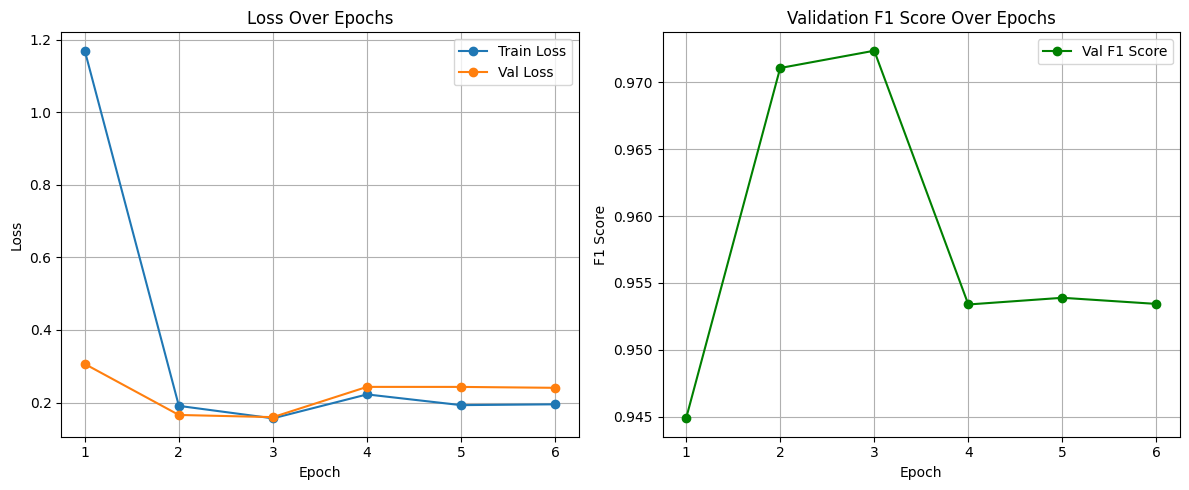

In [7]:
import matplotlib.pyplot as plt

def visualize_history(history):
    """
    Visualizes the training and validation history.

    Args:
        history (dict): Dictionary containing training and validation metrics with keys:
                        - "train_loss": List of training loss values.
                        - "val_loss": List of validation loss values.
                        - "val_f1": List of validation F1 scores.
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Val Loss", marker="o")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Plot validation F1 score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["val_f1"], label="Val F1 Score", marker="o", color="green")
    plt.title("Validation F1 Score Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

visualize_history(history)


# Prediction

In [8]:
# Load the test CSV for predictions
test_csv_path = "/kaggle/input/ai-vs-human-generated-dataset/test.csv"
test_df = pd.read_csv(test_csv_path)

# Define the base directory where images are stored
test_data_dir = "/kaggle/input/ai-vs-human-generated-dataset"

# Update image paths in the test dataframe
test_df['img_path'] = test_df['id'].apply(lambda x: os.path.join(test_data_dir, x))

In [9]:
%%time

# Initialize a list to store results
predictions = []

# Perform inference on test images
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    # if idx==100:
    #     break
    
    img_path = row['img_path']  # Path to the image
    id_ = row['id']
    try:
        # Open and preprocess image
        image = np.array(Image.open(img_path).convert("RGB"))
        input_tensor = val_transform(image=image)['image'].unsqueeze(0).to(device)  # Add batch dimension

        # Model prediction
        with torch.no_grad():
            outputs = model(input_tensor)
            predicted_label = torch.argmax(outputs, dim=-1).item()  # Get predicted class

        predictions.append((id_, predicted_label))
    except Exception as e:
        print(f"Error processing {img_path}: {e}")


100%|██████████| 19986/19986 [11:28<00:00, 29.05it/s]

CPU times: user 9min 32s, sys: 47.3 s, total: 10min 19s
Wall time: 11min 28s


In [10]:
# Create a DataFrame for submission
submission_df = pd.DataFrame(predictions, columns=["id", "label"])

# Save to CSV for submission
submission_csv_path = "submission.csv"
submission_df.to_csv(submission_csv_path, index=False)
print(f"Submission file saved at {submission_csv_path}")

Submission file saved at submission.csv


In [11]:
value_counts = submission_df['label'].value_counts()
value_counts

label
1    10012
0     9974
Name: count, dtype: int64

In [12]:
submission_df.head()

,id,label
0,test_data/e25323c62af644fba97afb846261b05b.jpg,1
1,test_data/63c7596c97d74c1cb6323db1b7380d5e.jpg,0
2,test_data/0a5eb7abb22b439580836e22d89e8ca1.jpg,0
3,test_data/371eddabfc1349a08534ce2292c4c4d3.jpg,0
4,test_data/7280ea6acaa14a52b7218ae36305b218.jpg,1
